In [1]:
# Before we begin, we supress deprecation warnings resulting from nltk on Kaggle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Linear SVM classification of sentiment in tweets about airlines

This notebook describes an attempt to classify tweets by sentiment. It describes the initial data exploration, as well as implementation of a linear one-vs-rest Support-Vector-Machine (SVM) classifier.

## What is in the dataset?

It's always good to start by exploring the data that we have available. To do this we load the raw csv file using [Pandas][1] and check what the columns are.

  [1]: http://pandas.pydata.org/

In [2]:
import pandas as pd
tweets = pd.read_csv("C:\\Users\\Win 1809 UEFI\\Desktop\\0.csv")
list(tweets.columns.values)

['airline',
 'review date',
 'Type Of Traveller',
 'seat type',
 'Seat Comfort',
 'Cabin Staff Service',
 'Food & Beverages',
 'Inflight Entertainment',
 'Ground Service',
 'Wifi & Connectivity',
 'Value For Money',
 'airline_sentiment',
 'Recommended',
 'overal rating(10)',
 'title',
 'review']

We want to be able to determine the sentiment of a tweet without any other information but the tweet text itself, hence the 'text' column is our focus. Using the text we are going to try and predict 'airline_sentiment'.

First we take a look at what a typical record looks like.

In [3]:
tweets.head()

,airline,review date,Type Of Traveller,seat type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,airline_sentiment,Recommended,overal rating(10),title,review
0,air arabia,2019,Solo Leisure,Economy Class,5.0,5.0,5.0,5.0,5.0,NaN,5,Negative,1,10,I will fly them again,I flew from Beirut to Sharjah on Air Arabia. C...
1,air arabia,2019,Solo Leisure,Economy Class,1.0,1.0,NaN,NaN,1.0,NaN,1,Negative,0,1,200 riyals as fine for the baggage,I was flying from Hyderabad to Bahrain via Sha...
2,air arabia,2019,Family Leisure,Economy Class,1.0,1.0,NaN,NaN,1.0,NaN,1,Negative,0,1,Absolute disaster,Not sure how this airline is allowed to legall...
3,air arabia,2019,Couple Leisure,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,1,Negative,0,1,nobody let us know about cancellation,We bought two tickets from Prague to Kathmandu...
4,air arabia,2019,Solo Leisure,Economy Class,3.0,3.0,3.0,1.0,1.0,1.0,3,Negative,0,1,Never using Air Arabia again,Worst experience. I am a student and i was tra...


Now lets take a look at what sentiments have been found.

In [5]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.review.count()
print(sentiment_counts)

Negative    2386
Positive    1373
Neutral     1095
Name: airline_sentiment, dtype: int64


It turns out that our dataset is unbalanced with significantly more negative than positive tweets. We will focus on the issue of identifying negative tweets, and hence treat neutral and positive as one class. It's good to keep in mind that, while a terrible classifier, if we always guessed a tweet was negative we'd be right 62.7% of the time (9178 of 14640). That clearly wouldn't be a very useful classifier, but worth to remember.

# What characterizes text of different sentiments?

While we still haven't decided what classification method to use, it's useful to get an idea of how the different texts look. This might be an "old school" approach in the age of deep learning, but lets indulge ourselves nevertheless. 

To explore the data we apply some crude preprocessing. We will tokenize and lemmatize using [Python NLTK][1], and transform to lower case. As words mostly matter in context we'll look at bi-grams instead of just individual tokens.

As a way to simplify later inspection of results we will store all processing of data together with it's original form. This means we will extend the Pandas dataframe into which we imported the raw data with new columns as we go along.

### Preprocessing
Note that we remove the first two tokens as they always contain "@ airline_name". We begin by defining our normalization function.


  [1]: http://www.nltk.org/

In [6]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [6]:
normalizer("Here is text about an airline I like.")

['text', 'airline', 'like']

In [10]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.review.apply(normalizer)
tweets[['review','normalized_tweet']].head()

,review,normalized_tweet
0,I flew from Beirut to Sharjah on Air Arabia. Check in was easy as I did it on line. I showed my boarding pass on my phone to get through security. At the gate I changed my e boarding pass to a paper ticket as that was required. Although they loaded a lot of cargo we took off on time. I had three seats to my self and was able to sleep. I was given water and dates which were very nice. I will fly them again.,"[beirut, sharjah, air, arabia, check, easy, line, showed, boarding, pas, phone, get, security, gate, changed, e, boarding, pas, paper, ticket, required, although, loaded, lot, cargo, took, time, three, seat, self, able, sleep, given, water, date, nice, fly]"
1,"I was flying from Hyderabad to Bahrain via Sharjah,while I was transit to Bahrain at Sharjah airport the ground staff of weighed hand bag & laptop was carrying on cabin then demanded to pay 200 riyals as fine for the baggage. I had no chance to debate with them because of their horrible attitude towards passengers. I suggest you don't waste your valuable time & money by flying with Air Arabia for their worst hospitality & cheap flight tickets.","[flying, hyderabad, bahrain, via, sharjah, transit, bahrain, sharjah, airport, ground, staff, weighed, hand, bag, laptop, carrying, cabin, demanded, pay, riyal, fine, baggage, chance, debate, horrible, attitude, towards, passenger, suggest, waste, valuable, time, money, flying, air, arabia, worst, hospitality, cheap, flight, ticket]"
2,"Not sure how this airline is allowed to legally operate?? They cancelled flights with no notice and cost us over £500 in additional costs to get to destination. They offered no reason, no compensation and ignored most of the communications between myself and them. Absolute disaster. Never again. They need to be banned from operating within the EU.","[airline, allowed, legally, operate, cancelled, flight, notice, cost, u, additional, cost, get, destination, offered, reason, compensation, ignored, communication, absolute, disaster, never, need, banned, operating, within, eu]"
3,"We bought two tickets from Prague to Kathmandu via Sharjah in November 2018. We were supposed to leave April 13, 2019, Ten days before the flight we tried to add some food and to change baggage allowance through internet browser. It must be said that their website does not work optimal in any of the internet browsers. We managed to change baggage allowance but no food. From that reason we log out and tried to add food later but we realized we don´t have access to our PNR anymore. We had still ten days to departure so we tried to contact their customer service via e-mail. Till now we do not have any answer. We contacted sales department in Prague by phone and also personally. They proved our PNR with conclusion we had cancelled both tickets in internet browser ourselves and the flight is full. We are still in shock. Two weeks of holiday, year of preparations for our big way to Himalayas, another friend waiting us in Kathmandu, services paid in Nepal are gone. Mainly, nobody let us know about tickets cancellation. If I wasn´t interested about my PNR, I wouldn´t know yet my tickets are cancelled. As proof they just reproduced conclusion of their IT Department in Sharjah. You have no chance to get in touch with somebody from their central agency in Sharjah. Mainly I would like to point out that I do not get any document confirming ticket cancellation. Welcome in modern times full of IT technologies where human being is a poor individual and those big fish use it for making money","[two, ticket, prague, kathmandu, via, sharjah, november, supposed, leave, april, ten, day, flight, tried, add, food, change, baggage, allowance, internet, browser, must, said, website, work, optimal, internet, browser, managed, change, baggage, allowance, food, reason, log, tried, add, food, later, realized, access, pnr, anymore, still, ten, day, departure, tried, contact, customer, service, via, e, mail, till, answer, co

In [11]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
0,"[beirut sharjah, sharjah air, air arabia, arabia check, check easy, easy line, line showed, showed boarding, boarding pas, pas phone, phone get, get security, security gate, gate changed, changed e, e boarding, boarding pas, pas paper, paper ticket, ticket required, required although, although loaded, loaded lot, lot cargo, cargo took, took time, time three, three seat, seat self, self able, able sleep, sleep given, given water, water date, date nice, nice fly, beirut sharjah air, sharjah air arabia, air arabia check, arabia check easy, check easy line, easy line showed, line showed boarding, showed boarding pas, boarding pas phone, pas phone get, phone get security, get security gate, security gate changed, gate changed e, changed e boarding, e boarding pas, boarding pas paper, pas paper ticket, paper ticket required, ticket required although, required although loaded, although loaded lot, loaded lot cargo, lot cargo took, cargo took time, took time three, time three seat, three seat self, seat self able, self able sleep, able sleep given, sleep given water, given water date, water date nice, date nice fly]"
1,"[flying hyderabad, hyderabad bahrain, bahrain via, via sharjah, sharjah transit, transit bahrain, bahrain sharjah, sharjah airport, airport ground, ground staff, staff weighed, weighed hand, hand bag, bag laptop, laptop carrying, carrying cabin, cabin demanded, demanded pay, pay riyal, riyal fine, fine baggage, baggage chance, chance debate, debate horrible, horrible attitude, attitude towards, towards passenger, passenger suggest, suggest waste, waste valuable, valuable time, time money, money flying, flying air, air arabia, arabia worst, worst hospitality, hospitality cheap, cheap flight, flight ticket, flying hyderabad bahrain, hyderabad bahrain via, bahrain via sharjah, via sharjah transit, sharjah transit bahrain, transit bahrain sharjah, bahrain sharjah airport, sharjah airport ground, airport ground staff, ground staff weighed, staff weighed hand, weighed hand bag, hand bag laptop, bag laptop carrying, laptop carrying cabin, carrying cabin demanded, cabin demanded pay, demanded pay riyal, pay riyal fine, riyal fine baggage, fine baggage chance, baggage chance debate, chance debate horrible, debate horrible attitude, horrible attitude towards, attitude towards passenger, towards passenger suggest, passenger suggest waste, suggest waste valuable, waste valuable time, valuable time money, time money flying, money flying air, flying air arabia, air arabia worst, arabia worst hospitality, worst hospitality cheap, hospitality cheap flight, cheap flight ticket]"
2,"[airline allowed, allowed legally, legally operate, operate cancelled, cancelled flight, flight notice, notice cost, cost u, u additional, additional cost, cost get, get destination, destination offered, offered reason, reason compensation, compensation ignored, ignored communication, communication absolute, absolute disaster, disaster never, never need, need banned, banned operating, operating within, within eu, airline allowed legally, allowed legally operate, legally operate cancelled, operate cancelled flight, cancelled flight notice, flight notice cost, notice cost u, cost u additional, u additional cost, additional cost get, cost get destination, get destination offered, destination offered reason, offered reason compensation, reason compensation ignored, compensation ignored communication, ignored communication absolute, communication absolute disaster, absolute disaster never, disaster never need, never need banned, need banned operating, banned operating within, operating within eu]"
3,"[two ticket, ticket prague, prague kathmandu, kathmandu via, via sharjah, sharjah november, november supposed, supposed leave, leave april, april ten, ten day, day flight, flight tried, tried add, add food, food change, change baggage, baggage allowance, allowance internet, internet browser, browser must, must said, said website, website work, work optimal,

And now some counting.

In [14]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [41]:
tweets[(tweets.airline_sentiment == 'negative')][['grams']].apply(count_words)['grams']


nan

We can already tell there's a pattern here. Sentences like "cancelled flight", "late flight", "booking problems",  "delayed flight" stand out clearly. Lets check the positive tweets.

In [19]:
tweets[(tweets.airline_sentiment == 'positive')][['grams']].apply(count_words)['grams']

nan

Some more good looking patterns here. We can however see that with 3-grams clear patterns are rare. "great customer service" occurs 12 times in 2362 positive responses, which really doesn't say much in general. 

Satisfied that our data looks possible to work with begin to construct our first classifier.

# Linear SVM classifier
We will build a simple, linear Support-Vector-Machine (SVM) classifier. The classifier will take into account each unique word present in the sentence, as well as all consecutive words. To make this representation useful for our SVM classifier we transform each sentence into a vector. The vector is of the same length as our vocabulary, i.e. the list of all words observed in our training data, with each word representing an entry in the vector. If a particular word is present, that entry in the vector is 1, otherwise 0.

To create these vectors we use the CountVectorizer from [sklearn][1]. 


  [1]: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Preparing the data

In [20]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [22]:
vectorized_data = count_vectorizer.fit_transform(tweets.review)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [24]:
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Neutral': 1,
        'Positive' : 2
    }[sentiment]
targets = tweets.airline_sentiment.apply(sentiment2target)

To check performance of our classifier we want to split our data in to train and test.

In [25]:
from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

## Fitting the classifier

We're now ready to fit the classifier to our data. We'll spend more time on hyper parameter tuning later, so for now we just pick some reasonable guesses. Note here that we use the OneVsRestClassifier. This allows us to get the probability distribution over all three classes. Behind the scenes we actually create three classifiers. Each of these classifiers determines the probability that the datapoint belongs to it's corresponding class, or any of the other classes. Hence the name OneVsRest.

In [26]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
clf_output = clf.fit(data_train, targets_train)

## Evaluation of results

In [27]:
clf.score(data_test, targets_test)

0.5417095777548918

It's most likely possible to achieve a higher score with more tuning, or a more advanced approach. Lets check on how it does on a couple of sentences.

In [28]:
sentences = count_vectorizer.transform([
    "What a great airline, the trip was a pleasure!",
    "My issue was quickly resolved after calling customer support. Thanks!",
    "What the hell! My flight was cancelled again. This sucks!",
    "Service was awful. I'll never fly with you again.",
    "You fuckers lost my luggage. Never again!",
    "I have mixed feelings about airlines. I don't know what I think.",
    ""
])
clf.predict_proba(sentences)

array([[0.44742314, 0.21497132, 0.33760554],
       [0.38933424, 0.21293726, 0.3977285 ],
       [0.46183854, 0.1960791 , 0.34208236],
       [0.52294389, 0.20500897, 0.27204714],
       [0.50038688, 0.19455051, 0.30506261],
       [0.45184917, 0.19888444, 0.34926638],
       [0.45500853, 0.20756098, 0.33743049]])

So while results aren't very impressive overall, we can see that it's doing a good job on these obvious sentences. 

## What is hard for the classifier?

It's interesting to know which sentences are hard. To find out, lets apply the classifier to all our test sentences and sort by the marginal probability.

Here are some of the hardest sentences.

In [29]:
predictions_on_test_data = clf.predict_proba(data_test)
index = np.transpose(np.array([range(0,len(predictions_on_test_data))]))
indexed_predictions = np.concatenate((predictions_on_test_data, index), axis=1).tolist()

In [31]:
def marginal(p):
    top2 = p.argsort()[::-1]
    return abs(p[top2[0]]-p[top2[1]])
margin = sorted(list(map(lambda p : [marginal(np.array(p[0:3])),p[3]], indexed_predictions)), key=lambda p : p[0])
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].review, margin[0:10]))

['Check-in and boarding in Cape Town were smooth. The flight to Dubai on a B777 was pleasant, with a comfortable seat which had adequate storage, and excellent food. The service was efficient but rather formal. The IFE on this flight was quite clunky. At Dubai we were bussed to the terminal, but as there was a dedicated Business Class bus this process was quite painless. Both the terminal itself and the Emirates lounge were very busy just after midnight. The second flight on an A380 was a big step up in luxury, with a more spacious seat, much more storage, more friendly cabin crew and very smooth IFE. Something went wrong with my vegetarian meal order, but it was cheerfully fixed. All in all a good experience.',
 ' Tallin to Singapore via Istanbul. It was my first time flying with Turkish on long haul flight and I was expecting a good experience. The food was bad on all the flights we had. The A330-300 from Istanbul to Singapore seemed old. The touch screens were not working normally, 

and their probability distributions?

In [32]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[0:10]))

[array([0.34523002, 0.30963503, 0.34513496]),
 array([0.37329894, 0.25320246, 0.3734986 ]),
 array([0.38429004, 0.3839978 , 0.23171216]),
 array([0.36435664, 0.27066729, 0.36497607]),
 array([0.36213288, 0.27645426, 0.36141285]),
 array([0.38178277, 0.23568127, 0.38253595]),
 array([0.34533388, 0.31020216, 0.34446396]),
 array([0.41374828, 0.41285583, 0.17339588]),
 array([0.40528169, 0.18790892, 0.40680939]),
 array([0.35714661, 0.28378483, 0.35906856])]

How about the easiest sentences?

In [33]:
list(map(lambda p : tweets.iloc[data_test_index[int(p[1])].toarray()[0][0]].review, margin[-10:]))

['  Kilaminjaro to Chicago via Istanbul. My problems began the day before the flight, I had booked a Turkish Airlines award business class ticket using United Mileageplus miles months earlier, but the day before noticed I couldn\'t select my seat and part of my flights were missing from the itinerary. I called Turkish Airlines to confirm everything was but for some reason I couldn\'t select my seat, so to arrive to the airport early. I arrive the next day to the airport 3 hours early in Kiliminjaro airport in Tanzania and it turns out there is a massive problem with my ticket. A Turkish airlines agent later said it was "it was award ticket and NO REC on your onward boarding pass"" which I have no idea what it means but the agent was smashing away at the keyboard for hours trying to get me on the flight to the point they had to hold the flight to Istanbul. At the very last minute I was finally I was able to board and the Turkish airlines agent said I shouldn\'t have any more problems, b

and their probability distributions?

In [34]:
list(map(lambda p : predictions_on_test_data[int(p[1])], margin[-10:]))

[array([0.83927641, 0.15528079, 0.0054428 ]),
 array([0.80588326, 0.11993946, 0.07417727]),
 array([0.83598591, 0.14973393, 0.01428016]),
 array([0.80991653, 0.1116305 , 0.07845297]),
 array([0.84558568, 0.13788772, 0.0165266 ]),
 array([0.83249298, 0.11428938, 0.05321764]),
 array([0.83156732, 0.11326797, 0.05516471]),
 array([0.83910267, 0.11167507, 0.04922226]),
 array([0.85328033, 0.08139333, 0.06532634]),
 array([0.8747255 , 0.09478096, 0.03049353])]

Looks like all of the easiest sentences are negative. What is the distribution of certainty across all sentences?

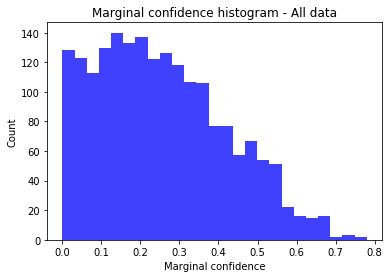

In [36]:
import matplotlib.pyplot as plt
marginal_probs = list(map(lambda p : p[0], margin))
n, bins, patches = plt.hist(marginal_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - All data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

Lets break it down by positive and negative sentiment to see if one is harder than the other.

### Positive data

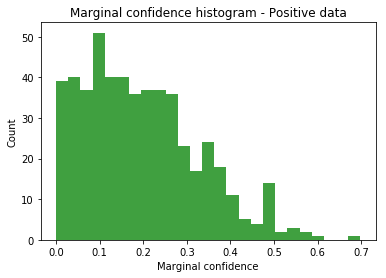

In [37]:
positive_test_data = list(filter(lambda row : row[0]==2, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='green', alpha=0.75)
plt.title('Marginal confidence histogram - Positive data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### Neutral data

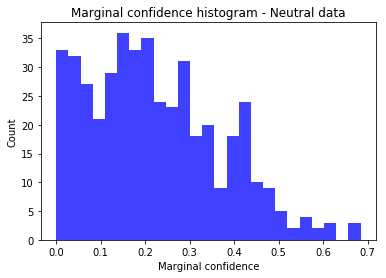

In [38]:
positive_test_data = list(filter(lambda row : row[0]==1, hstack((targets_test[:,None], data_test)).toarray()))
positive_probs = clf.predict_proba(list(map(lambda r : r[1:], positive_test_data)))
marginal_positive_probs = list(map(lambda p : marginal(p), positive_probs))
n, bins, patches = plt.hist(marginal_positive_probs, 25, facecolor='blue', alpha=0.75)
plt.title('Marginal confidence histogram - Neutral data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

### Negative data

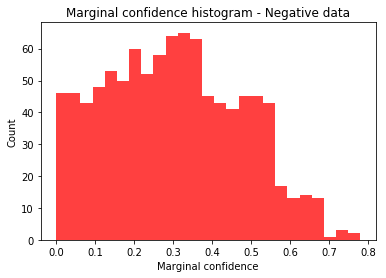

In [39]:
negative_test_data = list(filter(lambda row : row[0]==0, hstack((targets_test[:,None], data_test)).toarray()))
negative_probs = clf.predict_proba(list(map(lambda r : r[1:], negative_test_data)))
marginal_negative_probs = list(map(lambda p : marginal(p), negative_probs))
n, bins, patches = plt.hist(marginal_negative_probs, 25, facecolor='red', alpha=0.75)
plt.title('Marginal confidence histogram - Negative data')
plt.ylabel('Count')
plt.xlabel('Marginal confidence')
plt.show()

Clearly the positive data is much harder for the classifier. This makes sense since there's a lot less of it. An important challenge in building a better classifier will then be how to handle positive data.

A more advanced classifier is described here.